对材料的phonon cutoff frequency进行ML建模与预测
</br><1>数据集扩充➡345条,包含具有稳定性与非稳定性的钙钛矿


# Import pkgs And Utils

In [1]:
# 导入基础所用的pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
import random
import pickle

#AutoML
from flaml import AutoML
# kflod
from sklearn.model_selection import KFold

In [2]:
# UtilTools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 对预测结果进行评估
def regression_metrics(true,pred):
    print('回归模型评估指标结果:》》》》》》》》》》》》')
    #预测值与真实值的绝对平方误差的平均值（方差误差-mse）
    print('均方误差【MSE】:', mean_squared_error(true, pred))
    print('均方根误差【RMSE】:',np.sqrt(mean_squared_error(true,pred)))
    #预测值与真实值的绝对误差的平均值     
    print('平均绝对误差【MAE】:',mean_absolute_error(true,pred))
    print('预测精度R方得分【R2】: ',r2_score(true, pred))
    
    result_dict = {
    'model_name': automl.best_estimator,
    'r2': r2_score(true, pred),
    'mae': mean_absolute_error(true,pred),
    'rmse':np.sqrt(mean_squared_error(true,pred))
    }
    return result_dict

In [3]:
#Performng standard scaling--标准化处理
from sklearn.preprocessing import StandardScaler

def dataStandardScaler(X):
    std_scale = StandardScaler().fit(X) # 标准化、归一化的结果
    X_std = std_scale.transform(X)     # 格式转化-》 numpy
    # 格式转化-》pandas
    X_std = pd.DataFrame(X_std,
                         columns=X.columns,
                         index=X.index)
    return X_std

In [4]:
# R2图
from sklearn.metrics import r2_score
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    # 设置字体为Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.weight'] = 'bold'
    # 字体
    plt.rcParams.update({'font.size':20})
    
    plot = plt.figure(figsize=(16,10))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([10, xy_max], [10, xy_max], 'k--', label='ideal')  ## 对角线
    ##绘制拟合线
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=1, label='linear fit') ## 拟合线
    
    plt.axis('scaled') # x 、y 区间范围一致
    plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
    plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
    plt.xlabel(f'{label}') # x坐标轴名称
    plt.ylabel(f'Predicted {label}') # y坐标轴名称
    # plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}') # 图的标题
    # plt.title(f'{model}, r2: {r2_score(act, pred):0.4f}') # 图的标题
    plt.legend([f'{model}, r2: {r2_score(act, pred):0.4f}'],loc='upper left') # 图例 loc：位置
    
    return plot

In [5]:
# 统计数据分布情况
def countResult(df_count,columnName):     
    df_condition = df_count
    columnName = columnName
    result_dict={}
    for j in range(0,130,10):
        condition = (df_condition[columnName] >= j) & (df_condition[columnName] < j+10)
        subset = df_condition[condition]
        count = len(subset)
        key = "["+str(j)+","+str(j+10)+"]"
        result_dict[key]=count
    return result_dict

In [6]:
# 设置 Pandas 显示选项
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

# 显示全部 
# 设置 Pandas 显示选项
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# Import Data

In [14]:
# 导入phonon数据
path = "train_data/phonon1/trainData(2).csv"
df_phonon = pd.read_csv(path)
df_phonon.dropna(axis=1,how='all',inplace=True)
df_phonon

,number,material_id,formula,Wmax,nsites,volume,density,spg_num,a,b,...,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_min,TC_max,TC_mean,TC_std
0,1,mp-775761,AgClO3,25.7900,20,291.0597,4.3660,198,6.6272,6.6272,...,38.2639,47.5837,0.6000,1.6000,0.8800,0.5237,0.0089,430.0000,86.0177,229.8328
1,2,mp-849271,AgIO3,21.9200,20,331.9799,5.6576,62,5.9151,6.6458,...,56.5542,66.8590,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.1057,229.7741
2,3,mp-8196,AgNO3,42.3900,5,66.9431,4.2137,160,4.1518,4.1518,...,33.9746,49.3830,0.6000,1.6000,0.8100,0.5285,0.0258,430.0000,86.0211,229.8306
3,4,mp-558637,AgTeO3,20.5400,40,574.8262,6.5509,14,11.8267,6.0246,...,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.6159,229.4383
4,5,mp-561489,AgTeO3,21.8000,20,274.1800,6.8671,11,5.4617,6.9181,...,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.6159,229.4383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,341,mp-13334,ZnSnO3,20.3000,10,117.5701,6.5568,161,5.6591,5.6591,...,46.4234,54.6504,0.6000,1.4500,0.9200,0.5254,0.0266,120.0000,37.4159,65.1625
341,342,mp-16819,ZnTeO3,23.0700,40,572.6336,5.5910,61,6.3291,7.3393,...,48.2014,58.8920,0.6000,1.4000,0.9100,0.5078,0.0266,120.0000,24.6159,63.7497
342,343,mp-647557,ZrPbO3,23.0900,40,605.8365,7.5961,32,6.0423,8.3861,...,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,0.0266,35.0000,11.6159,19.6337
343,344,mp-755798,ZrPbO3,22.8500,20,291.6364,7.8899,62,5.8893,5.9274,...,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,0.0266,35.0000,11.6159,19.6337


In [15]:
# 目标列
target_phonon = df_phonon.loc[:,'Wmax'] 
target_phonon 

0     25.7900
1     21.9200
2     42.3900
3     20.5400
4     21.8000
        ...  
340   20.3000
341   23.0700
342   23.0900
343   22.8500
344   23.4600
Name: Wmax, Length: 345, dtype: float64

In [16]:
# 特征列
featureset_phonon = df_phonon.iloc[:,4:]
featureset_phonon.head()

,nsites,volume,density,spg_num,a,b,c,alpha,beta,gamma,...,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_min,TC_max,TC_mean,TC_std
0,20,291.0597,4.3660,198,6.6272,6.6272,6.6272,90.0000,90.0000,90.0000,...,38.2639,47.5837,0.6000,1.6000,0.8800,0.5237,0.0089,430.0000,86.0177,229.8328
1,20,331.9799,5.6576,62,5.9151,6.6458,8.4451,90.0000,90.0000,90.0000,...,56.5542,66.8590,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.1057,229.7741
2,5,66.9431,4.2137,160,4.1518,4.1518,4.1518,77.2242,77.2242,77.2242,...,33.9746,49.3830,0.6000,1.6000,0.8100,0.5285,0.0258,430.0000,86.0211,229.8306
3,40,574.8262,6.5509,14,11.8267,6.0246,9.2212,61.0332,90.0000,90.0000,...,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.6159,229.4383
4,20,274.1800,6.8671,11,5.4617,6.9181,7.3998,90.0000,90.0000,101.3022,...,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,0.0266,430.0000,86.6159,229.4383


In [17]:
# 计算特征集合的方差
# 计算特征方差
variance = featureset_phonon.var()
pd.set_option('display.float_format', '{:.4f}'.format)
print(variance)

nsites      230.8422
volume    47209.6923
density       3.4095
spg_num    4735.4389
a             2.9120
             ...    
Ra_std        0.0168
TC_min        0.0000
TC_max     7796.6253
TC_mean     414.2452
TC_std     2185.3329
Length: 100, dtype: float64


In [18]:
# 输出删除的特征名
drop_features = variance[variance < 0.001]
print("方差小于0.0001的特征长度：", len(drop_features.index))
print("方差小于0.0001的特征：", drop_features.index)

# 保留方差大于0.01的特征
Variance_Selected_features = variance[variance >= 0.001]
print("方差大于0.0001的特征长度：", len(Variance_Selected_features.index))
print("方差大于0.0001的特征：", Variance_Selected_features.index)

方差小于0.0001的特征长度： 8
方差小于0.0001的特征： Index(['EG_max', 'NsV_max', 'NdV_min', 'NfV_min', 'NsU_min', 'NdU_min',
       'NfU_min', 'TC_min'],
      dtype='object')
方差大于0.0001的特征长度： 92
方差大于0.0001的特征： Index(['nsites', 'volume', 'density', 'spg_num', 'a', 'b', 'c', 'alpha',
       'beta', 'gamma', 'Ef', 'Eg', 'Num_min', 'Num_max', 'Num_mean',
       'Num_std', 'MenNum_min', 'MenNum_max', 'MenNum_mean', 'MenNum_std',
       'Tm_min', 'Tm_max', 'Tm_mean', 'Tm_std', 'Column_min', 'Column_max',
       'Column_mean', 'Column_std', 'Row_min', 'Row_max', 'Row_mean',
       'Row_std', 'Rc_min', 'Rc_max', 'Rc_mean', 'Rc_std', 'EG_min', 'EG_mean',
       'EG_std', 'NsV_min', 'NsV_mean', 'NsV_std', 'NpV_min', 'NpV_max',
       'NpV_mean', 'NpV_std', 'NdV_max', 'NdV_mean', 'NdV_std', 'NfV_max',
       'NfV_mean', 'NfV_std', 'NV_min', 'NV_max', 'NV_mean', 'NV_std',
       'NsU_max', 'NsU_mean', 'NsU_std', 'NpU_min', 'NpU_max', 'NpU_mean',
       'NpU_std', 'NdU_max', 'NdU_mean', 'NdU_std', 'NfU_max', 'NfU_me

# Feature engineering

In [19]:
# 复制源数据集
df_copy_1 = df_phonon_train.copy()
# 经过方差筛选后特征集合
varianceFeatureSet = ['Wmax'] + Variance_Selected_features.index.to_list()
df_features_varianced = df_copy_1.loc[:,varianceFeatureSet]
df_features_varianced

,Wmax,nsites,volume,density,spg_num,a,b,c,alpha,beta,...,AtomM_max,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_max,TC_mean,TC_std
0,25.7900,20,291.0597,4.3660,198,6.6272,6.6272,6.6272,90.0000,90.0000,...,107.8682,38.2639,47.5837,0.6000,1.6000,0.8800,0.5237,430.0000,86.0177,229.8328
1,21.9200,20,331.9799,5.6576,62,5.9151,6.6458,8.4451,90.0000,90.0000,...,126.9045,56.5542,66.8590,0.6000,1.6000,0.9600,0.5952,430.0000,86.1057,229.7741
2,42.3900,5,66.9431,4.2137,160,4.1518,4.1518,4.1518,77.2242,77.2242,...,107.8682,33.9746,49.3830,0.6000,1.6000,0.8100,0.5285,430.0000,86.0211,229.8306
3,20.5400,40,574.8262,6.5509,14,11.8267,6.0246,9.2212,61.0332,90.0000,...,127.6000,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,430.0000,86.6159,229.4383
4,21.8000,20,274.1800,6.8671,11,5.4617,6.9181,7.3998,90.0000,90.0000,...,127.6000,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,430.0000,86.6159,229.4383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,20.3000,10,117.5701,6.5568,161,5.6591,5.6591,5.6591,56.4281,56.4281,...,118.7100,46.4234,54.6504,0.6000,1.4500,0.9200,0.5254,120.0000,37.4159,65.1625
341,23.0700,40,572.6336,5.5910,61,6.3291,7.3393,12.3277,90.0000,90.0000,...,127.6000,48.2014,58.8920,0.6000,1.4000,0.9100,0.5078,120.0000,24.6159,63.7497
342,23.0900,40,605.8365,7.5961,32,6.0423,8.3861,11.9561,90.0000,90.0000,...,207.2000,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,35.0000,11.6159,19.6337
343,22.8500,20,291.6364,7.8899,62,5.8893,5.9274,8.3543,90.0000,90.0000,...,207.2000,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,35.0000,11.6159,19.6337


## RFE

In [22]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost 

# 定义一个rf model
modelRF = RandomForestRegressor(
                        # n_estimators= 200,
                        random_state=45
                                )
# 定义一个xgb model
params = {'max_depth': 6, # 决策树的最大深度 
          'learning_rate': 0.1, # 学习率 
          'n_estimators': 100, # 弱分类器（决策树）的个数 
          'objective': 'reg:squarederror',# 损失函数，这里使用均方误差 
          'random_state': 42 # 随机种子 
         }
model_xgb = xgboost.XGBRegressor(**params)

In [23]:
# 数据划分
ref_feature = df_features_varianced.iloc[:,1:]
ref_feature_std = dataStandardScaler(ref_feature)
target = df_features_varianced['Wmax']
x_train,x_test,y_train,y_test = train_test_split(ref_feature_std,
                                                 target,
                                                 test_size=0.2,
                                                 random_state=45)

In [24]:
# 定义 RFE 对象
rfe = RFE(modelRF, n_features_to_select=30, verbose=1)

# 训练模型
rfe.fit(x_train, y_train)

# 获取被选择的特征的索引
selected_features_index = rfe.support_

# 获取被选择的特征的名称
selected_features_name = x_train.columns[selected_features_index]

# 选择特征
selected_features = rfe.transform(x_train)

# 将特征数据转换为 pandas 格式
selected_features_df = pd.DataFrame(selected_features, columns=selected_features_name)

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 fe

In [25]:
# 筛选完后的特征集合
selected_feature_columns =selected_features_df.columns
selected_feature_columns

Index(['volume', 'density', 'b', 'Ef', 'Num_min', 'Num_std', 'MenNum_min',
       'MenNum_mean', 'MenNum_std', 'Tm_min', 'Tm_max', 'Tm_std', 'Column_std',
       'Row_mean', 'Rc_min', 'Rc_mean', 'EG_mean', 'NpV_std', 'NdV_max',
       'NdV_std', 'NV_max', 'NpU_max', 'NpU_mean', 'NU_min', 'GSV_min',
       'GSV_max', 'AtomM_min', 'Ra_min', 'Ra_mean', 'TC_std'],
      dtype='object')

In [37]:
# 进一步特征筛选-pearson
list_FeatureColumns = list(selected_feature_columns)
list_FeatureColumns.append("Wmax")
ref_selected_feature = df_features_varianced[list_FeatureColumns]

# 删除与Wmax小于0.2的特征
df_feature_rfe_corr = ref_selected_feature
corr = abs(df_feature_rfe_corr.corr().loc['Wmax']) 
corr = corr[corr<0.2] 
cols_to_drop = corr.index.to_list() 
df_features_phonon_select_1 = df_feature_rfe_corr.drop(cols_to_drop, axis=1)
df_PearsonSelected_1 = df_features_phonon_select_1.iloc[:,:19]
# df_PearsonSelected_1
# 删除高度相关的特征
phonon_correlation_matrix = df_PearsonSelected_1.corr()
# 筛选出pearson>0.8 的特征
phonon_correlated_features=set()
for i in range(len(phonon_correlation_matrix.columns)):
    for j in range(i):
        if abs(phonon_correlation_matrix.iloc[i,j]) > 0.8:
            colname = phonon_correlation_matrix.columns[i]
            phonon_correlated_features.add(colname)
phonon_featureSelected = df_PearsonSelected_1.drop(labels=phonon_correlated_features,axis=1)  
phonon_featureSelected.columns

Index(['density', 'Ef', 'Num_min', 'MenNum_min', 'Tm_min', 'Row_mean',
       'Rc_mean', 'NdV_max', 'NV_max', 'GSV_min'],
      dtype='object')

In [38]:
# 两步筛选(RFE,Pearson)完后的特征集合
colName = ['number','material_id','formula','Wmax',]+phonon_featureSelected.columns.to_list()

df_save_phonon = df_phonon_train.loc[:,colName]
df_save_phonon

,number,material_id,formula,Wmax,density,Ef,Num_min,MenNum_min,Tm_min,Row_mean,Rc_mean,NdV_max,NV_max,GSV_min
0,1,mp-775761,AgClO3,25.7900,4.3660,-0.4168,8,65,54.8000,2.8000,89.0000,10,11,9.1050
1,2,mp-849271,AgIO3,21.9200,5.6576,-0.6986,8,65,54.8000,3.2000,96.4000,10,17,9.1050
2,3,mp-8196,AgNO3,42.3900,4.2137,-0.6527,7,65,54.8000,2.6000,82.8000,10,11,9.1050
3,4,mp-558637,AgTeO3,20.5400,6.5509,-1.1288,8,65,54.8000,3.2000,96.2000,10,16,9.1050
4,5,mp-561489,AgTeO3,21.8000,6.8671,-1.1291,8,65,54.8000,3.2000,96.2000,10,16,9.1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,341,mp-13334,ZnSnO3,20.3000,6.5568,-1.9402,8,69,54.8000,3.0000,91.8000,10,14,9.1050
341,342,mp-16819,ZnTeO3,23.0700,5.5910,-1.6334,8,69,54.8000,3.0000,91.6000,10,16,9.1050
342,343,mp-647557,ZrPbO3,23.0900,7.5961,-2.8465,8,44,54.8000,3.4000,103.8000,10,28,9.1050
343,344,mp-755798,ZrPbO3,22.8500,7.8899,-2.8420,8,44,54.8000,3.4000,103.8000,10,28,9.1050


In [39]:
# # 两步筛选完后的特征集合， 进行保存
df_save_phonon.to_csv('train_data/phonon1/trainData(5-f10).csv')

In [ ]:
# 显示 heatmap
SS = list(phonon_featureSelected.columns)
SS.append('Wmax')
df2 = df_features_varianced[SS]
# phonon_featureSelected
# drop uncorrelated numeric features (threshold <0.2) 
corr = abs(df2.corr().loc['Wmax']) 
corr = corr[corr<0.2] 
cols_to_drop = corr.index.to_list() 
df_features_phonon_select = df2.drop(cols_to_drop, axis=1)

# # 查看 target与 feature之间的 heatmap
df_corr = df_features_phonon_select
sns.set(rc={'figure.figsize':(16,10)}) 
sns.heatmap(df_corr.corr(), 
            annot=True, 
            linewidths=.5, 
            center=0, 
            cbar=True, 
            cmap="RdBu") 
plt.show()

# model construction

In [6]:
df_train_selected = pd.read_csv("train_data/phonon1/trainData(4-f15).csv")
corr_matrix = df_train_selected.iloc[:,2:]
corr_matrix.head()

,formula,Wmax,density,Ef,Num_min,MenNum_min,MenNum_max,Tm_min,Rc_mean,NsV_min,NdV_max,NV_min,NV_max,NdU_max,NU_max,GSV_min,B_max
0,AgClO3,25.79,4.366023,-0.416786,8,65,94,54.8,89.0,1,10,6,11,0,2,9.105,3
1,AgIO3,21.92,5.657596,-0.698568,8,65,96,54.8,96.4,1,10,6,17,0,2,9.105,3
2,AgNO3,42.39,4.213744,-0.652688,7,65,87,54.8,82.8,1,10,5,11,0,3,9.105,3
3,AgTeO3,20.54,6.550948,-1.128791,8,65,90,54.8,96.2,1,10,6,16,0,2,9.105,3
4,AgTeO3,21.80,6.867123,-1.129141,8,65,90,54.8,96.2,1,10,6,16,0,2,9.105,3


In [7]:
# 通过 pearson相关系数 特征筛选完后的dataset

df_train_selected = pd.read_csv("train_data/phonon1/trainData(4-f15).csv")
feature_train = df_train_selected.iloc[:,4:]
target_train = df_train_selected["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature_train)

# 数据划分
x_train, x_test, y_train, y_test = train_test_split(feature_std,
                                                    target_train,
                                                    test_size=0.2,
                                                    random_state=45)

In [8]:
# 在使用Kflod 进行数据划分时，需要重新标序号
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_train

,density,Ef,Num_min,MenNum_min,MenNum_max,Tm_min,Rc_mean,NsV_min,NdV_max,NV_min,NV_max,NdU_max,NU_max,GSV_min,B_max
0,-0.652730,-1.534251,0.414032,-0.580726,-0.398569,0.143910,1.132559,0.644038,-1.084550,-0.017489,-1.054603,1.472685,0.991512,0.343891,0.806671
1,1.185346,-0.228471,0.414032,0.654157,-0.398569,0.143910,0.287848,0.644038,0.927115,0.531033,1.912200,1.220162,0.683894,0.343891,0.806671
2,1.419456,-0.581232,0.414032,0.242530,-0.398569,0.143910,0.136234,0.644038,0.927115,1.628078,-0.110620,-0.800022,-0.238962,0.343891,0.806671
3,0.760514,-0.157147,0.414032,-0.580726,-0.398569,0.143910,0.222870,0.644038,0.927115,-0.017489,2.047055,1.472685,0.991512,0.343891,0.806671
4,-1.818105,1.507371,-0.226511,-0.917512,-0.398569,0.143910,-1.531528,-1.472088,-1.308068,-1.114534,-1.054603,-0.800022,-0.854198,0.343891,-1.239663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,-0.518081,0.671536,-2.788682,-0.954933,-0.398569,0.143910,-0.881751,-1.472088,0.927115,-1.114534,0.159089,-0.800022,-0.854198,0.343891,-1.239663
272,1.243314,-0.225154,0.414032,-0.318781,-0.398569,0.143910,0.807670,-1.472088,0.927115,1.079555,-0.380329,1.472685,4.682932,0.343891,0.806671
273,-0.742554,2.048685,-4.069768,2.263248,3.658990,-6.948792,-2.982698,-1.472088,0.927115,-1.114534,0.428799,-0.800022,-1.161817,-2.502426,-1.239663
274,0.608557,0.439429,0.414032,-0.730409,-0.398569,0.143910,0.352826,0.644038,0.927115,-0.566011,2.047055,-0.800022,-0.854198,0.343891,-1.239663


## model train

In [14]:
# 添加自定义的GBR model
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.data import CLASSIFICATION

class MyGradientBoostingRegressor(SKLearnEstimator):
    def __init__(self, task='binary',n_jobs=None, **config):
        '''Constructor
        Args:
            task: A string of the task type, one of
                'binary', 'multi', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''
        super().__init__(task,**config)
        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from sklearn.ensemble import GradientBoostingClassifier
            self.estimator_class = GradientBoostingClassifier
        else:
            from sklearn.ensemble import GradientBoostingRegressor
            self.estimator_class = GradientBoostingRegressor
    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space
        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {
            'loss':{'domain':tune.choice(['squared_error', 'absolute_error', 'huber', 'quantile'])},
            'max_depth': {'domain': tune.randint(lower=1, upper=50)},
            'n_estimators': {'domain': tune.randint(lower=1, upper=1000), 'low_cost_init_value': 4},
            'subsample':{'domain':tune.loguniform(lower=0.01, upper=1.0)},
            'max_features': {'domain': tune.loguniform(lower=0.1, upper=0.99)},
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0)},
            'min_samples_split': {'domain': tune.loguniform(lower=0.1, upper=1.0)},
        }
        return space
automl = AutoML()   
automl.add_learner("gbr", MyGradientBoostingRegressor)

In [70]:
# 填写Automl设置
settings = {
            "time_budget": 240,  # 总时间上限(单位秒)
            "metric": 'r2',  # 候选可以是: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
            # "estimator_list": ['xgboost','lgbm','catboost','rf','gbr'],
            # "estimator_list": ['xgboost'],
            # "estimator_list": ['lgbm'],
            # "estimator_list": ['catboost'],
            # "estimator_list": ['rf'],
            "estimator_list": ['gbr'],
            "task": 'regression',  # 任务类型
            "eval_method":'cv',
            "n_splits":10,
            # "log_file_name": 'log files/phonon_log_files/phonon_train_lgbm.log',  # flaml日志文件
            # "seed": 46,    # 随机种子
}

In [71]:
# 添加 10Kflod 
kFold=KFold(n_splits=10, random_state=56, shuffle=True)
automl.fit(X_train=x_train, y_train=y_train, **settings, split_type=kFold)

[flaml.automl.automl: 11-09 16:11:18] {2726} INFO - task = regression
[flaml.automl.automl: 11-09 16:11:18] {2728} INFO - Data split method: KFold(n_splits=10, random_state=56, shuffle=True)
[flaml.automl.automl: 11-09 16:11:18] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 11-09 16:11:18] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 11-09 16:11:18] {3004} INFO - List of ML learners in AutoML Run: ['gbr']
[flaml.automl.automl: 11-09 16:11:18] {3334} INFO - iteration 0, current learner gbr
[flaml.automl.automl: 11-09 16:11:18] {3472} INFO - Estimated sufficient time budget=908s. Estimated necessary time budget=1s.
[flaml.automl.automl: 11-09 16:11:18] {3519} INFO -  at 0.1s,	estimator gbr's best error=1.1307,	best estimator gbr's best error=1.1307
[flaml.automl.automl: 11-09 16:11:18] {3334} INFO - iteration 1, current learner gbr
[flaml.automl.automl: 11-09 16:11:18] {3519} INFO -  at 0.6s,	estimator gbr's best error=1.1307,	best estimator gbr's best er

In [72]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: gbr
Best hyperparmeter config: {'n_estimators': 408, 'loss': 'huber', 'max_depth': 9, 'subsample': 0.8673679029019715, 'max_features': 0.2808590900436512, 'learning_rate': 0.09151856051084202, 'min_samples_split': 0.38524988319704745}
Best accuracy on validation data: 0.9175
Training duration of best run: 1.058 s


In [68]:
## model saved
# result/11-8(f15)/Model/

path_saveModel = 'result/11-8(f15)/Model/automl-'+automl.best_estimator+'.pkl'
store = path_saveModel
with open(store, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
## 模型加载
# 'result/11-8(f15)/Model/

path_loadModel = 'result/11-8(f15)/Model/automl-xgboost.pkl'
store = path_loadModel
with open(store, 'rb') as f:
    automl = pickle.load(f)

回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 7.848120612052429
均方根误差【RMSE】: 2.8014497339863924
平均绝对误差【MAE】: 1.7590596438813255
预测精度R方得分【R2】:  0.9526148150594567


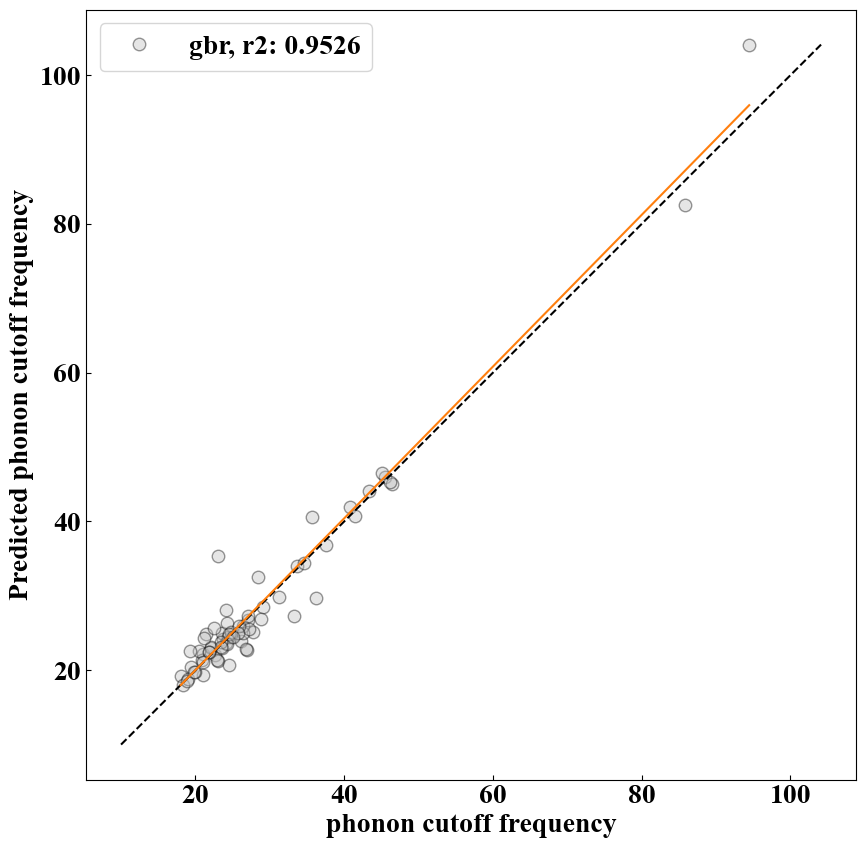

In [73]:
# predict metrics
ypred = automl.predict(x_test)
pred_result = regression_metrics(y_test,ypred)
plot=plot_pred_act(
    y_test,ypred,
    automl.best_estimator,
    reg_line=True,label='phonon cutoff frequency')

In [74]:
# 保存训练结果数据
# result\PIC\phonon_result_r2_pic
plot.savefig('result/11-8(f15)/PIC/'+automl.best_estimator+'_result.jpg', format='jpg', dpi=1000, bbox_inches='tight')

In [75]:
# 创建包含 y_test 和 ypred 的 DataFrame
results_df = pd.DataFrame({'y_test': y_test, 'ypred': ypred})
# results_df
# 将结果保存为 CSV 文件
# result/11-8(f15)/Model/automl-'+automl.best_estimator+'.pkl
results_df.to_csv('result/11-8(f15)/Model/'+automl.best_estimator+'-prediction_results.csv', index=False)

results_df

,y_test,ypred
200,29.13,28.456441
310,22.60,22.003408
315,22.15,23.041735
63,33.25,27.354406
266,24.81,24.508574
...,...,...
30,24.50,20.753656
190,27.06,27.271698
262,25.11,24.508574
250,20.99,21.081845


## Result of trained

In [22]:
# 记录10 kflod cv train result

df_train_result = pd.DataFrame(columns=['ML model','hyperparmeter','10KflodCV'])

In [76]:
# pd.concat(df_train_result,pd.DataFrame({'ML model':automl.best_estimator,
#                         'hyperparmeter':automl.best_config,
#                         '10KflodCV':1-automl.best_loss}))
df_train_result=df_train_result.append({'ML model':automl.best_estimator,
                                        'hyperparmeter':automl.best_config,
                                        '10KflodCV':1-automl.best_loss}, ignore_index=True)

C:\Users\94497\AppData\Local\Temp\ipykernel_22348\228668703.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_result=df_train_result.append({'ML model':automl.best_estimator,


In [77]:
df_train_result

,ML model,hyperparmeter,10KflodCV
0,xgboost,"{'n_estimators': 24, 'max_leaves': 21, 'min_ch...",0.939892
1,lgbm,"{'n_estimators': 56, 'num_leaves': 59, 'min_ch...",0.945724
2,catboost,"{'early_stopping_rounds': 15, 'learning_rate':...",0.918892
3,rf,"{'n_estimators': 12, 'max_features': 0.6074030...",0.928772
4,gbr,"{'n_estimators': 408, 'loss': 'huber', 'max_de...",0.917452


In [77]:
df_train_result

,ML model,hyperparmeter,10KflodCV
0,lgbm,"{'n_estimators': 56, 'num_leaves': 59, 'min_ch...",0.945724
1,catboost,"{'early_stopping_rounds': 17, 'learning_rate':...",0.916802
2,rf,"{'n_estimators': 12, 'max_features': 0.6163810...",0.928112
3,gbr,"{'n_estimators': 566, 'loss': 'huber', 'max_de...",0.936220


In [80]:
df_train_result.to_csv('result/11-8(f15)/Model/ML_train_result.csv')

## Result of predicted

In [25]:
df_pred_result = pd.DataFrame(columns=['model_name','r2','mae','rmse'])

In [78]:
df_pred_result = df_pred_result.append(pred_result, ignore_index=True)

C:\Users\94497\AppData\Local\Temp\ipykernel_22348\2644397907.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred_result = df_pred_result.append(pred_result, ignore_index=True)


In [79]:
df_pred_result

,model_name,r2,mae,rmse
0,xgboost,0.967292,1.631205,2.327497
1,lgbm,0.973322,1.339655,2.102043
2,catboost,0.966534,1.544911,2.354323
3,rf,0.925761,1.855133,3.506522
4,gbr,0.952615,1.759060,2.801450


In [81]:
df_pred_result.to_csv('result/11-8(f15)/Model/pred_result.csv')

# SHAP analyse

In [82]:
# 导包
import shap
import lightgbm as lgb

In [94]:
# 通过 pearson相关系数 特征筛选完后的dataset

df_train_selected = pd.read_csv("train_data/phonon1/trainData(4-f15).csv")
feature_train = df_train_selected.iloc[:,4:]
target_train = df_train_selected["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature_train)

# 数据划分
# x_train, x_test, y_train, y_test = train_test_split(feature_std,
#                                                     target_train,
#                                                     test_size=0.2,
#                                                     random_state=45)

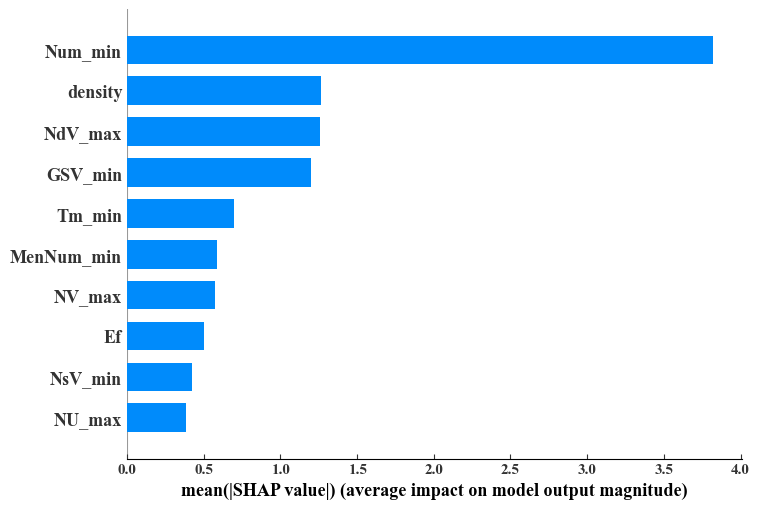

In [97]:
# params ={'n_estimators': 27,
#          'num_leaves': 70,
#          'min_child_samples': 2,
#          'learning_rate': 0.15056166681183433,
#          # 'log_max_bin': 10,
#          'colsample_bytree': 0.6816088762511493,
#          'reg_alpha': 0.0020145913289276885,
#          'reg_lambda': 0.036371692462722476}

params = {'n_estimators': 56,
          'num_leaves': 59,
          'min_child_samples': 3,
          'learning_rate': 0.20965284786018218,
          # 'log_max_bin': 7,
          'colsample_bytree': 0.5614656111885798,
          'reg_alpha': 0.0009765625,
          'reg_lambda': 0.022677313474640613}

# 初始化LightGBM回归模型
model_lgb_shap = lgb.LGBMRegressor(**params)
model_lgb_shap.fit(feature_std, target_train)

# 计算 shap值
shap_values = shap.Explainer(model_lgb_shap).shap_values(feature_std)
# 绘制SHAP 得到的特征重要性排名
shap.summary_plot(shap_values, feature_std, plot_type="bar", max_display=10, show=False)

# 保存图片
# plt.savefig('result/11-8(f15)/heatmap-1.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.savefig('result/11-8(f15)/PIC/shap_feature_importance.jpg', format='jpg', dpi=1000, bbox_inches='tight')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


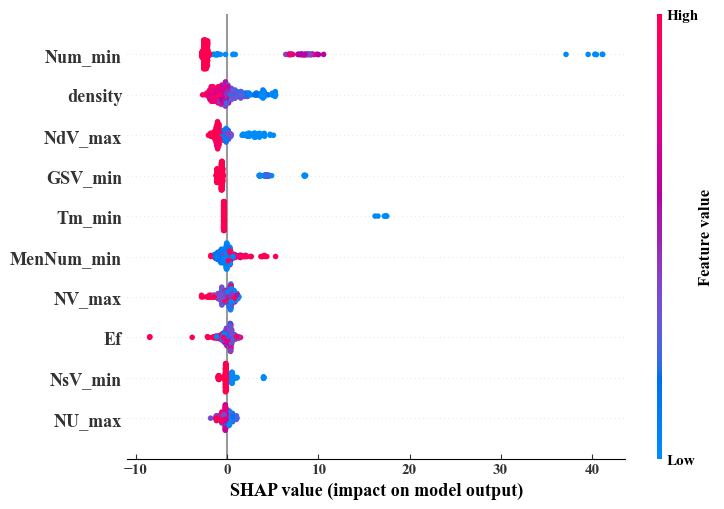

<Figure size 640x480 with 0 Axes>

In [121]:
# 显示预测因子与目标变量之间的正负关系
shap.summary_plot(shap_values, feature_std, max_display=10, plot_type="dot")
plt.show()

# 保存图片
plt.savefig('result/11-8(f15)/PIC/shap_relationship.jpg', format='jpg', dpi=1000)

In [116]:
# 显示预测因子与目标变量之间的正负关系
shap.plots.beeswarm(shap_values, feature_std)
plt.show()

# 保存图片
plt.savefig('result/11-8(f15)/PIC/shap_relationship.jpg', format='jpg', dpi=1000)

ValueError: the beeswarm plot requires Explanation object as the `shap_values` argument